# Exploratary data analysis 

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sbs
import geopandas as gpd
import folium 
from folium.plugins import HeatMap


In [2]:
# Load the Parquet file into a Pandas DataFrame
df = pd.read_parquet("../data/curated/tlc_data/first_cleaned.parquet/")


## Data processing

In [3]:
# Drop rows with any missing values
clean_df = df.dropna()

# Check the number of remaining rows
remaining_rows = clean_df.shape[0]
total_rows = df.shape[0]

print(f"Remaining rows after dropping missing values: {remaining_rows} out of {total_rows}")

# Print percentage of rows remaining
print(f"Percentage of rows remaining: {remaining_rows / total_rows * 100:.2f}%")


Remaining rows after dropping missing values: 3594010 out of 3695979
Percentage of rows remaining: 97.24%


In [4]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Prevent line breaks in the output

# Get summary statistics for all columns, including non-numerical ones
summary_stats = clean_df.describe(include='all')

# Display the summary statistics
print(summary_stats)

        DOLocationID  PULocationID pickup_date   pickup_hour dropoff_date  dropoff_hour      VendorID  passenger_count  trip_distance  trip_duration    RatecodeID store_and_fwd_flag  PUBorough  DOBorough  payment_type   fare_amount         extra       mta_tax    tip_amount  tolls_amount  improvement_surcharge  total_amount  congestion_surcharge  ehail_fee  hourly_trip_count  daily_trip_count           CIG           WND           VIS           TMP           DEW           SLP  Number of Events
count   3.594010e+06  3.594010e+06     3594010  3.594010e+06      3594010  3.594010e+06  3.594010e+06     3.594010e+06   3.594010e+06   3.594010e+06  3.594010e+06            3594010    3594010    3594010  3.594010e+06  3.594010e+06  3.594010e+06  3.594010e+06  3.594010e+06  3.594010e+06           3.594010e+06  3.594010e+06          3.594010e+06  3594010.0       3.594010e+06      3.594010e+06  3.594010e+06  3.594010e+06  3.594010e+06  3.594010e+06  3.594010e+06  3.594010e+06      3.594010e+06
unique

### Hourly demand

In [6]:
# Group by 'pickup_hour' and 'PUBorough' to get the sum of trips and average weather data
hourly_demand = clean_df.groupby(['pickup_hour', 'PUBorough']).agg({
    'hourly_trip_count': 'sum',
    'TMP': 'mean',
    'VIS': 'mean',
    'Number of Events': 'sum'
}).reset_index()

# Rename the columns to match the desired output
hourly_demand.rename(columns={
    'hourly_trip_count': 'total_hourly_trips',
    'TMP': 'avg_temperature',
    'VIS': 'avg_visibility',
    'Number of Events': 'total_events'
}, inplace=True)

# Round the average temperature and visibility to 1 decimal place
hourly_demand['avg_temperature'] = hourly_demand['avg_temperature'].round(1)
hourly_demand['avg_visibility'] = hourly_demand['avg_visibility'].round(1)

# Show the first 10 rows of the aggregated result
print(hourly_demand.head(5))


   pickup_hour  PUBorough  total_hourly_trips  avg_temperature  avg_visibility  total_events
0            0      Bronx               45665             10.2          1295.1             0
1            0   Brooklyn             4421514              7.7          1162.8          1808
2            0  Manhattan           441795812              7.7          1171.8       4161927
3            0     Queens            26490456              8.6          1177.9           191
4            1      Bronx               76298              8.2          1036.3             0


### Daily demand

In [7]:
# Group by 'pickup_date' and 'PUBorough' to get the sum of trips and average weather data
daily_demand = clean_df.groupby(['pickup_date', 'PUBorough']).agg({
    'daily_trip_count': 'sum',
    'TMP': 'mean',
    'VIS': 'mean',
    'Number of Events': 'sum'
}).reset_index()

# Rename the columns to match the desired output
daily_demand.rename(columns={
    'daily_trip_count': 'total_daily_trips',
    'TMP': 'avg_temperature',
    'VIS': 'avg_visibility',
    'Number of Events': 'total_events'
}, inplace=True)

# Round the average temperature and visibility to 1 decimal place
daily_demand['avg_temperature'] = daily_demand['avg_temperature'].round(1)
daily_demand['avg_visibility'] = daily_demand['avg_visibility'].round(1)

# Show the first 5 rows of the aggregated result
print(daily_demand.head(5))


  pickup_date  PUBorough  total_daily_trips  avg_temperature  avg_visibility  total_events
0  2023-12-01      Bronx            3172260              7.6          1356.4            26
1  2023-12-01   Brooklyn           44411640              7.8          1144.2           488
2  2023-12-01        EWR             226590              7.1           523.0             0
3  2023-12-01  Manhattan        13001960790              7.9          1211.0        384609
4  2023-12-01     Queens         1216561710              7.9          1284.4         17293


## Distribution Analysis 

In [8]:
# Step 1: Load the shapefile of NYC boroughs
gdf = gpd.read_file("../data/landing/external/geo_export_f16e615f-62c7-40bb-856c-2cccde28f16b.shp")

# Convert to GeoJSON
geojson_data = gdf.to_json()

# Check the first 5 rows of the GeoDataFrame
gdf.head(5)


,borough,location_i,objectid,shape_area,shape_leng,zone,geometry
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.695, -74.18449 40.69509..."
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."


In [9]:
# Total hourly trips by borough
agg_data = clean_df.groupby('PUBorough').agg({
    'hourly_trip_count': 'sum'
}).reset_index()

# Rename the columns to match the desired output
agg_data.rename(columns={'PUBorough': 'borough', 'hourly_trip_count': 'total_hourly_trips'}, inplace=True)

# Ensure the data is in the correct format by selecting only the relevant columns
agg_data = agg_data[['borough', 'total_hourly_trips']]

# Display the first 5 rows of the aggregated data
agg_data.head()


,borough,total_hourly_trips
0,Bronx,3774524
1,Brooklyn,56422914
2,EWR,189590
3,Manhattan,17030888713
4,Queens,1626943747


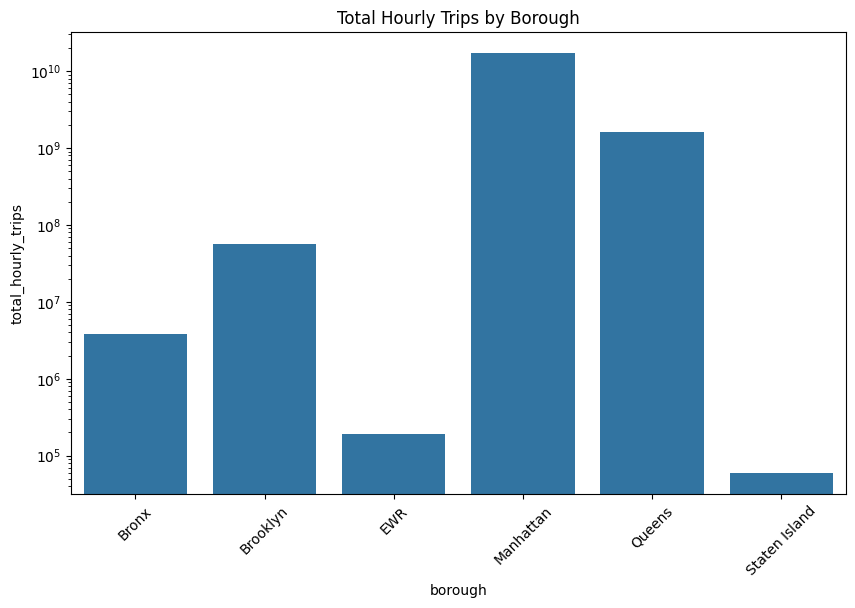

In [10]:
# Create a bar chart with a log scale
fig, ax = plt.subplots(figsize=(10, 6))

# Create the bar plot using Seaborn
sbs.barplot(x='borough', y='total_hourly_trips', data=agg_data, ax=ax)

# Set the y-axis to a logarithmic scale
ax.set_yscale('log')

# Set the title of the plot
ax.set_title('Total Hourly Trips by Borough')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


     borough  total_daily_trips
0      Bronx           80848508
1   Brooklyn         1142613603
2        EWR            3293250
3  Manhattan       319004298508
4     Queens        31100170396


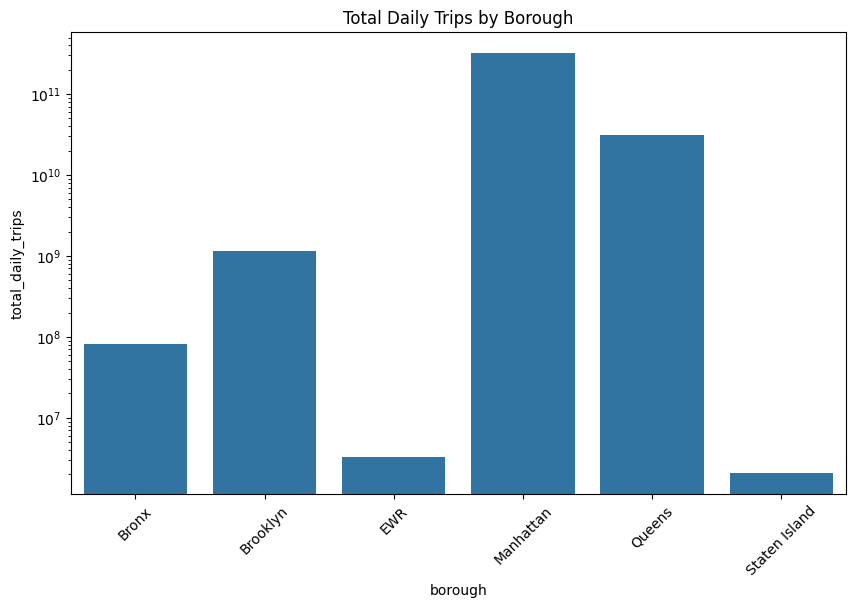

In [11]:
# Aggregate the number of daily trips by PUBorough
agg_data_daily = clean_df.groupby('PUBorough').agg({
    'daily_trip_count': 'sum'
}).reset_index()

# Rename the columns to match the expected output
agg_data_daily.rename(columns={'PUBorough': 'borough', 'daily_trip_count': 'total_daily_trips'}, inplace=True)

# Display the first 5 rows of the aggregated data
print(agg_data_daily.head())

# Create a bar chart with a log scale
fig, ax = plt.subplots(figsize=(10, 6))

# Create the bar plot using Seaborn
sbs.barplot(x='borough', y='total_daily_trips', data=agg_data_daily, ax=ax)

# Set the y-axis to a logarithmic scale
ax.set_yscale('log')

# Set the title of the plot
ax.set_title('Total Daily Trips by Borough')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


## Categorical Data Analysis

## Correlation Analysis 

In [12]:
# Calculate correlations for hourly trip count
temp_hourly_corr = clean_df['TMP'].corr(clean_df['hourly_trip_count'])
vis_hourly_corr = clean_df['VIS'].corr(clean_df['hourly_trip_count'])
events_hourly_corr = np.log1p(clean_df['Number of Events']).corr(clean_df['hourly_trip_count'])

# Calculate correlations for daily trip count
temp_daily_corr = clean_df['TMP'].corr(clean_df['daily_trip_count'])
vis_daily_corr = clean_df['VIS'].corr(clean_df['daily_trip_count'])
events_daily_corr = clean_df['Number of Events'].corr(clean_df['daily_trip_count'])

# Create a DataFrame to hold the correlation results
correlation_matrix = pd.DataFrame({
    'Correlation': ['temp_hourly_corr', 'vis_hourly_corr', 'events_hourly_corr', 
                    'temp_daily_corr', 'vis_daily_corr', 'events_daily_corr'],
    'Value': [temp_hourly_corr, vis_hourly_corr, events_hourly_corr, 
              temp_daily_corr, vis_daily_corr, events_daily_corr]
})

# Display the correlation matrix
print(correlation_matrix)


          Correlation     Value
0    temp_hourly_corr -0.092072
1     vis_hourly_corr  0.293338
2  events_hourly_corr  0.082076
3     temp_daily_corr -0.232243
4      vis_daily_corr  0.375171
5   events_daily_corr  0.119199


## Bivariate Analysis

### Number of events vs dates

In [29]:
# print features
print(clean_df.columns)

Index(['DOLocationID', 'PULocationID', 'pickup_date', 'pickup_hour',
       'dropoff_date', 'dropoff_hour', 'VendorID', 'passenger_count',
       'trip_distance', 'trip_duration', 'RatecodeID', 'store_and_fwd_flag',
       'PUBorough', 'DOBorough', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'ehail_fee',
       'hourly_trip_count', 'daily_trip_count', 'CIG', 'WND', 'VIS', 'TMP',
       'DEW', 'SLP', 'Number of Events'],
      dtype='object')


/var/folders/gf/ml3nsztn0cb376sq34z0ll1r0000gn/T/ipykernel_5809/1388855362.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['Event Date'] = pd.to_datetime(clean_df['pickup_date']).dt.date


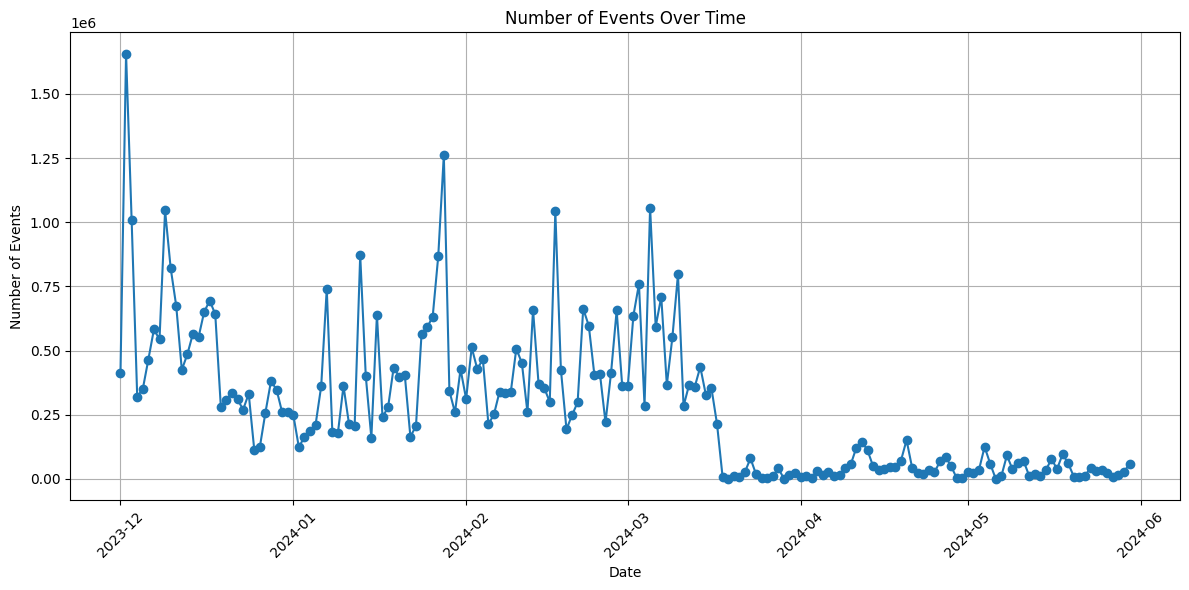

In [32]:
# Convert 'pickup_date' to datetime and extract just the date part if not already done
clean_df['Event Date'] = pd.to_datetime(clean_df['pickup_date']).dt.date

# Assuming you want to count actual events, you should group by 'Event Date' in edf
# Group by 'Event Date' and count the number of events
events_per_date_df = clean_df.groupby('Event Date').agg({'Number of Events': 'sum'}).reset_index()

# Plot the date vs number of events
plt.figure(figsize=(12, 6))
plt.plot(events_per_date_df['Event Date'], events_per_date_df['Number of Events'], marker='o', linestyle='-')
plt.title('Number of Events Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()
